# Example of using ioh-explainer

First we need to define the configuration space of an algorithm. We take a standard PSO algorithm as example.

In [1]:
from ConfigSpace import ConfigurationSpace
from ConfigSpace.util import generate_grid

cs = ConfigurationSpace({
    "F": (0.05, 2.0),              # Uniform float
    "CR" : (0.05, 2.0),                    # Uniform float
})

steps_dict = {
    "F": 20, 
    "CR" : 20,
}

In [2]:
from ioh_explainer.core import explainer
import pyswarms as ps
from modde import ModularDE, Parameters
import numpy as np


def run_de(func, config, budget, dim, *args, **kwargs):
    item = {'F': np.array([float(config.get('F'))]), 'CR':np.array([float(config.get('CR'))]),  'lambda_' : 10*dim }
    c = ModularDE(func, **item)
    try:
        c.run()
        return []
    except Exception as e:
        print(f"Found target {func.state.current_best.y} target, but exception ({e}), so run failed")
        return []

de_explainer = explainer(run_de, 
                 cs , 
                 optimizer_args = None,
                 dims = [5,10],#, 10, 20, 40 
                 fids = [1,5], #,5
                 iids = 10, #20 
                 reps = 5, 
                 sampling_method = "grid",  #or random
                 grid_steps_dict = steps_dict,
                 sample_size = None,  #only used with random method
                 budget = 10000, #10000
                 seed = 1,
                 verbose = True)
de_explainer.run(paralell=True)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


<class 'ioh_explainer.core.explainer'>
Evaluating 400 configurations.


100%|██████████| 400/400 [13:19<00:00,  2.00s/it]

       fid  iid  dim  seed    CR     F           auc
0        1    0    5     0  0.05  0.05  1.015233e-08
1        1    1    5     0  0.05  0.05  1.579857e-06
2        1    2    5     0  0.05  0.05  3.828957e-04
3        1    3    5     0  0.05  0.05  1.772088e-11
4        1    4    5     0  0.05  0.05  5.428480e-04
...    ...  ...  ...   ...   ...   ...           ...
15995    5    5   10     0  2.00  2.00  0.000000e+00
15996    5    6   10     0  2.00  2.00  0.000000e+00
15997    5    7   10     0  2.00  2.00  0.000000e+00
15998    5    8   10     0  2.00  2.00  0.000000e+00
15999    5    9   10     0  2.00  2.00  0.000000e+00

[16000 rows x 7 columns]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


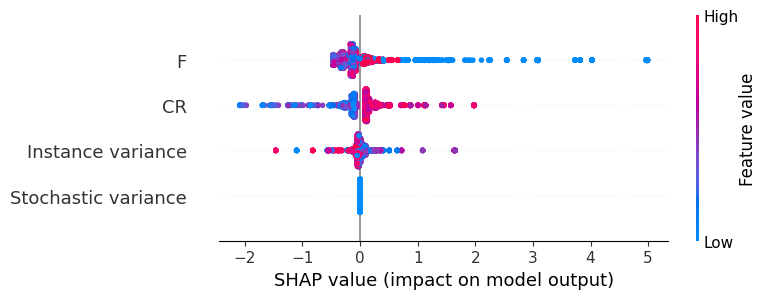

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


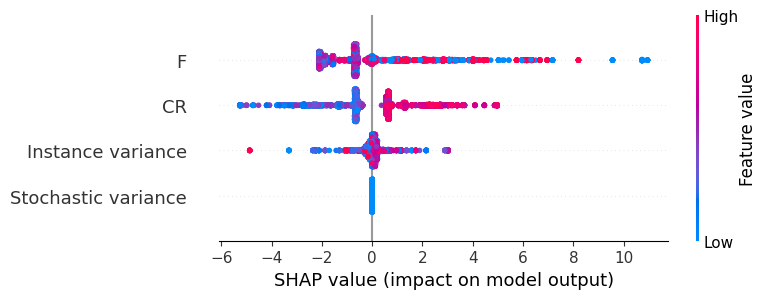

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


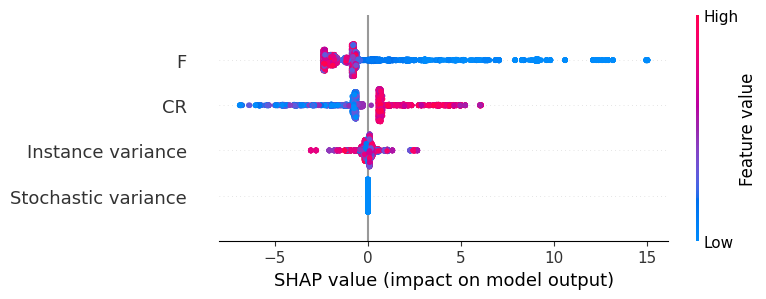

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


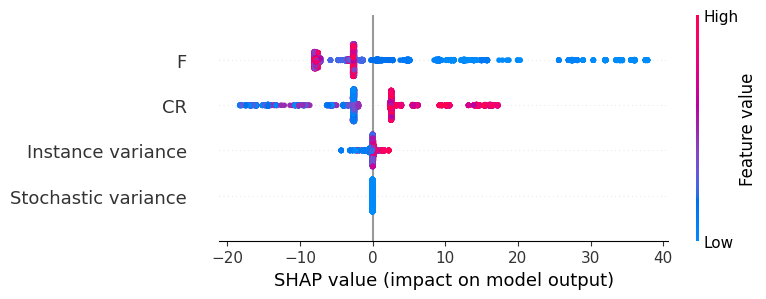

In [3]:

de_explainer.plot()


[1.01523265e-08 1.57985709e-06 3.82895659e-04 ... 2.66050873e+00
 1.98494768e-01 9.49402466e-01]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


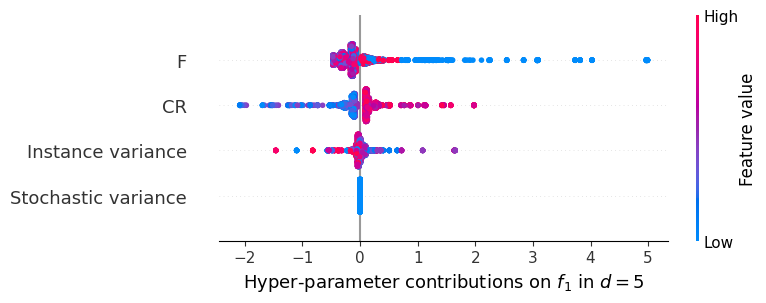

[6.47968909e-15 6.87211019e-15 2.10965775e-14 ... 2.64712445e+01
 1.44672578e+01 1.39140224e+01]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


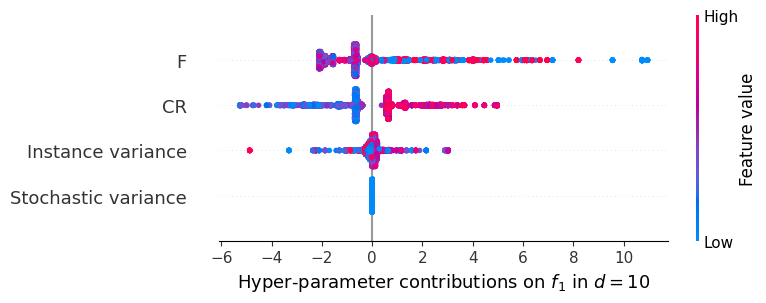

[0.60900853 0.         1.50994297 ... 0.         0.         0.        ]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


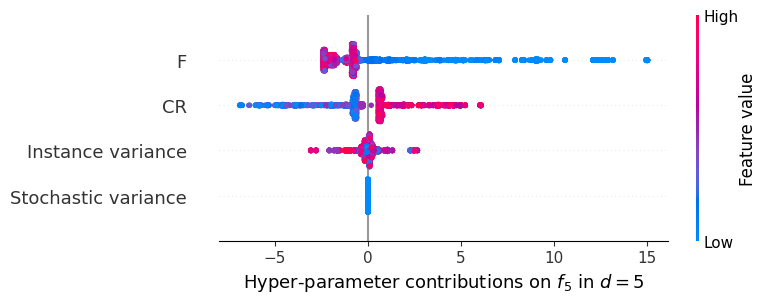

[0.11372846 0.         0.         ... 0.         0.         0.        ]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


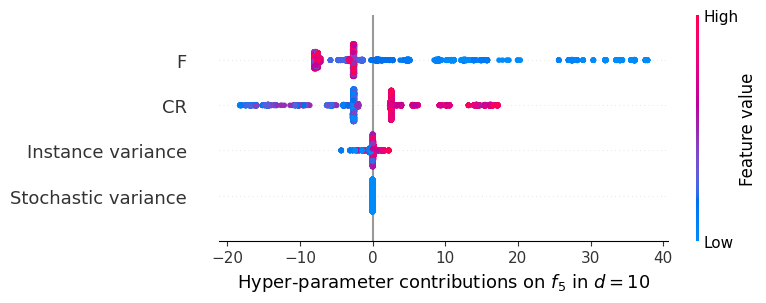

In [10]:
import xgboost
import shap
import matplotlib.pyplot as plt
df = de_explainer.df
df = df.rename(columns={"iid": "Instance variance", "seed": "Stochastic variance"})
for fid in de_explainer.fids:
    for dim in de_explainer.dims:
        subdf = df[(df['fid'] == fid) & (df['dim'] == dim)]
        X = subdf[[*de_explainer.config_space.keys(), 'Instance variance', 'Stochastic variance']]
        y = subdf['auc'].values
        print(y)
            
        # train xgboost model on diabetes data:
        bst = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

        # explain the model's prediction using SHAP values on the first 1000 training data samples
        shap_values = shap.TreeExplainer(bst).shap_values(X)
        plot = shap.summary_plot(shap_values, X, show=False)
        plt.xlabel(f'Hyper-parameter contributions on $f_{fid}$ in $d={dim}$')
        plt.title = f"$f_{fid} d={dim}$"
        plt.show()